# Transaction data analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
df = pd.read_csv("1_txn_data.csv")

In [3]:
df.head()

,adv_id,value_in_paise,payment_gateway,payment_method,payment_status,created_at,app_id,from_currency_amount,from_currency,to_currency_amount,to_currency,transaction_fee_amount,transaction_fee_currency
0,NaN,3000,RAZORPAY,UPI,PROCESSED,2024-10-18 09:34:14.247708+00:00,sikka,300.0,sikka,30.0,INR,130.0,paise
1,2d3ad81b-a068-460a-9f35-60d7df3c2b78,3000,RAZORPAY,UPI,PROCESSED,2024-10-18 09:34:14.247708+00:00,sikka,300.0,sikka,30.0,INR,130.0,paise
2,3052eb57-f48d-4bb5-9469-bf4e1c71c8a9,3000,RAZORPAY,UPI,PROCESSED,2024-10-18 09:34:14.247708+00:00,sikka,300.0,sikka,30.0,INR,130.0,paise
3,802684aa-0870-4258-9561-aa84f6aa88d8,3000,RAZORPAY,UPI,PROCESSED,2024-10-18 09:34:14.247708+00:00,sikka,300.0,sikka,30.0,INR,130.0,paise
4,92edbd60-5179-47ca-bb6d-122a157a27e0,3000,RAZORPAY,UPI,PROCESSED,2024-10-18 09:34:14.247708+00:00,sikka,300.0,sikka,30.0,INR,130.0,paise


In [4]:
# Drop rows with missing user IDs
df_clean = df.dropna(subset=['adv_id'])

df_clean.isna().sum()

adv_id                         0
value_in_paise                 0
payment_gateway                0
payment_method                 0
payment_status                 0
created_at                     0
app_id                         0
from_currency_amount           0
from_currency                  0
to_currency_amount             0
to_currency                    0
transaction_fee_amount         0
transaction_fee_currency    7484
dtype: int64

#### I cleaned the dataset by dropping any null adv_id values, filtered for successful transactions, and sorted them chronologically per user.

In [5]:
# Filter only successful transactions
df_success = df_clean[df_clean['payment_status'].str.upper() == 'PROCESSED'].copy()

# Sort by user and transaction datetime
df_success = df_success.sort_values(by=['adv_id', 'created_at'])

#### 1. From the 1_txn_data.csv dataset, I assume that only transactions with payment_status = 'PROCESSED' are valid. 

#### 2. Also, adv_id uniquely identifies a user.

In [6]:
# Assigning transaction rank per user
df_success['txn_rank'] = df_success.groupby('adv_id').cumcount() + 1
#df_success.head(5)

#### I assigned a rank to each transaction per user so I could isolate the first and second transactions

In [7]:
# Calculate average time to 2nd transaction
first_txn = df_success[df_success['txn_rank'] == 1][['adv_id', 'created_at']]
second_txn = df_success[df_success['txn_rank'] == 2][['adv_id', 'created_at']]

# Merge to compute the time difference
txn_diff = pd.merge(second_txn, first_txn, on='adv_id', suffixes=('_2nd', '_1st'))

# Ensure created_at columns are datetime
txn_diff['created_at_2nd'] = pd.to_datetime(txn_diff['created_at_2nd'], errors='coerce')
txn_diff['created_at_1st'] = pd.to_datetime(txn_diff['created_at_1st'], errors='coerce')

# Drop rows with invalid dates
txn_diff = txn_diff.dropna(subset=['created_at_2nd', 'created_at_1st'])

# Compute days between first and second transaction
txn_diff['days_to_2nd_txn'] = (txn_diff['created_at_2nd'] - txn_diff['created_at_1st']).dt.total_seconds() / (60 * 60 * 24)

# Metric 1: Average days to 2nd transaction
avg_days_to_2nd = txn_diff['days_to_2nd_txn'].mean()
print(f"1. Average time to 2nd transaction: {avg_days_to_2nd:.2f} days")

1. Average time to 2nd transaction: 1.64 days


### Metric 1: Time to 2nd Transaction

#### Using created_at, I calculated the average days between first and second transaction. This came out to 1.64 days, indicating fast return behavior.

In [8]:
# Metric 2: Percentage of users who did a second transaction
total_users = df_success['adv_id'].nunique()
users_with_2_txns = df_success[df_success['txn_rank'] >= 2]['adv_id'].nunique()
percent_users_with_2nd = (users_with_2_txns / total_users) * 100
print(f"2. Percentage of users with second transaction: {percent_users_with_2nd:.2f}%")

2. Percentage of users with second transaction: 23.92%


### Metric 2: Retention

#### About 23.92% of users made a second transaction. This is a critical metric for measuring drop-off.

In [9]:
# Metric 3: Average transaction amount after the first
# Convert paise to INR
df_success['value_in_inr'] = df_success['value_in_paise'] / 100
avg_txn_after_first = df_success[df_success['txn_rank'] > 1]['value_in_inr'].mean()
print(f"3. Average transaction amount after first: ₹{avg_txn_after_first:.2f} INR")

3. Average transaction amount after first: ₹52.18 INR


### Metric 3: Avg. Spend After First

#### For users who returned, I calculated the average transaction amount after their first. This was ₹52.18, useful for LTV or retention modeling.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


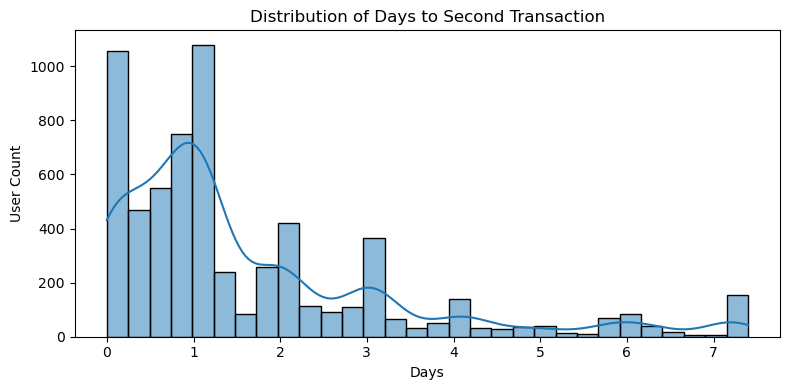

In [10]:
# Optional: Visualizations
# Distribution of days to 2nd transaction
plt.figure(figsize=(8, 4))
sns.histplot(txn_diff['days_to_2nd_txn'], bins=30, kde=True)
plt.title('Distribution of Days to Second Transaction')
plt.xlabel('Days')
plt.ylabel('User Count')
plt.tight_layout()
plt.show()

### Histogram: 
#### This shows the spread of how quickly users come back. Most return within 2–3 days.

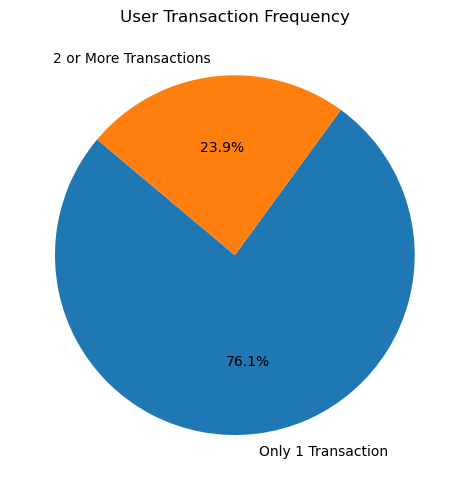

In [11]:
# Pie chart of users with and without 2nd transaction
labels = ['Only 1 Transaction', '2 or More Transactions']
values = [total_users - users_with_2_txns, users_with_2_txns]
plt.figure(figsize=(5, 5))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('User Transaction Frequency')
plt.tight_layout()
plt.show()

### Pie chart: 

#### This visualizes the split between one-time users vs. repeat users.

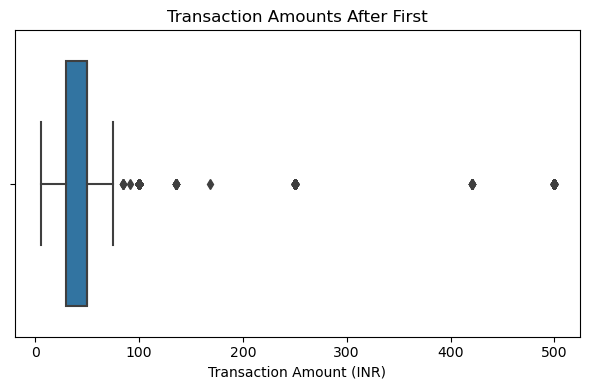

In [12]:
# Boxplot of transaction amount after first
plt.figure(figsize=(6, 4))
sns.boxplot(x=df_success[df_success['txn_rank'] > 1]['value_in_inr'])
plt.title('Transaction Amounts After First')
plt.xlabel('Transaction Amount (INR)')
plt.tight_layout()
plt.show()

### Boxplot:
#### This helps us see the distribution of post-first transaction amounts. There are a few high-value outliers.

## Insight :

#### less than a quarter of users return after their first transaction, but those who do return quickly and spend a modest amount. This can guide strategies for targeted re-engagement campaigns or flagging users with unusually large second spends for fraud checks.